libraries

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

# tf.keras.utils.Sequence
# tf.keras.layers
# tf.keras.Model

2025-04-22 10:49:35.450169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745318975.854545      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745318975.979496      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


get data

In [2]:
IMG_DIR = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
MASK_DIR = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"
IMG_SIZE = 224

# Get all filenames
filenames = os.listdir(IMG_DIR)
filenames = [f for f in filenames if f.endswith(".png")]

In [3]:
filenames

['COVID-1994.png',
 'COVID-1825.png',
 'COVID-517.png',
 'COVID-532.png',
 'COVID-2272.png',
 'COVID-765.png',
 'COVID-699.png',
 'COVID-1857.png',
 'COVID-3190.png',
 'COVID-774.png',
 'COVID-3113.png',
 'COVID-2563.png',
 'COVID-562.png',
 'COVID-2100.png',
 'COVID-2441.png',
 'COVID-2226.png',
 'COVID-1586.png',
 'COVID-2101.png',
 'COVID-3397.png',
 'COVID-415.png',
 'COVID-744.png',
 'COVID-258.png',
 'COVID-3032.png',
 'COVID-2424.png',
 'COVID-953.png',
 'COVID-2494.png',
 'COVID-1300.png',
 'COVID-2856.png',
 'COVID-2768.png',
 'COVID-1859.png',
 'COVID-1089.png',
 'COVID-2086.png',
 'COVID-2695.png',
 'COVID-2875.png',
 'COVID-1007.png',
 'COVID-1762.png',
 'COVID-46.png',
 'COVID-894.png',
 'COVID-107.png',
 'COVID-1399.png',
 'COVID-624.png',
 'COVID-39.png',
 'COVID-1138.png',
 'COVID-647.png',
 'COVID-1309.png',
 'COVID-843.png',
 'COVID-2433.png',
 'COVID-2293.png',
 'COVID-1454.png',
 'COVID-307.png',
 'COVID-3576.png',
 'COVID-2775.png',
 'COVID-1824.png',
 'COVID-2996.

In [4]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=16, img_size=224, shuffle=True):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        for file in batch_files:
            img = cv2.imread(os.path.join(self.img_dir, file), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            
            mask = cv2.imread(os.path.join(self.mask_dir, file), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)


segmentation model

In [5]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(224, 224, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)

    return tf.keras.Model(inputs, outputs)


prepare data

In [6]:
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state=42)

train_gen = DataGen(train_filenames, IMG_DIR, MASK_DIR)
val_gen = DataGen(val_filenames, IMG_DIR, MASK_DIR)

training

In [7]:
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

I0000 00:00:1745318994.621156      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745318994.621791      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745319009.758527      93 service.cc:148] XLA service 0x7eaa200237d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745319009.760583      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745319009.760607      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745319010.765132      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745319064.969324      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

 61/181 ━━━━━━━━━━━━━━━━━━━━ 1:18 656ms/step - accuracy: 0.7058 - loss: 0.5858

E0000 00:00:1745319122.245150      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745319122.483356      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745319129.518691      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745319129.758321      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.7411 - loss: 0.5151

E0000 00:00:1745319286.079876      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745319286.305193      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


181/181 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.7413 - loss: 0.5147 - val_accuracy: 0.8563 - val_loss: 0.3326
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 736ms/step - accuracy: 0.8842 - loss: 0.2650 - val_accuracy: 0.9437 - val_loss: 0.1233
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 137s 751ms/step - accuracy: 0.9493 - loss: 0.1091 - val_accuracy: 0.9549 - val_loss: 0.0928
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 734ms/step - accuracy: 0.9591 - loss: 0.0825 - val_accuracy: 0.9650 - val_loss: 0.0662
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 734ms/step - accuracy: 0.9671 - loss: 0.0616 - val_accuracy: 0.9682 - val_loss: 0.0580
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 135s 738ms/step - accuracy: 0.9700 - loss: 0.0525 - val_accuracy: 0.9720 - val_loss: 0.0476
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 735ms/step - accuracy: 0.9719 - loss: 0.0473 - val_accuracy: 0.9730 - val_loss: 0.0434
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 135s 739ms/step - accuracy: 0.9731 - loss: 0.0438 

predict and visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


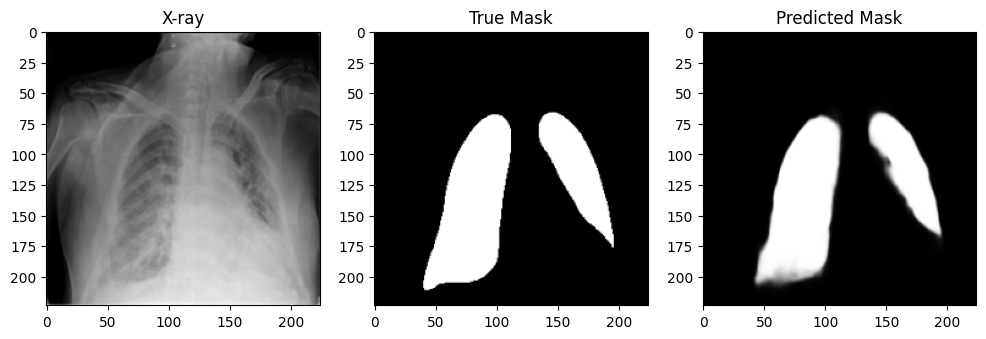

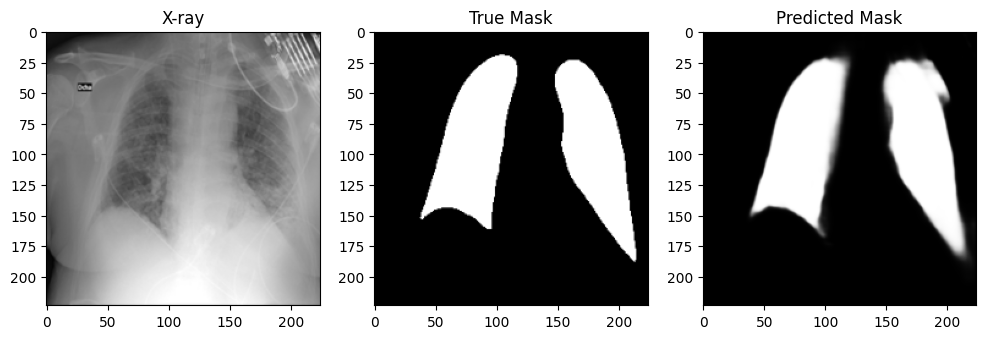

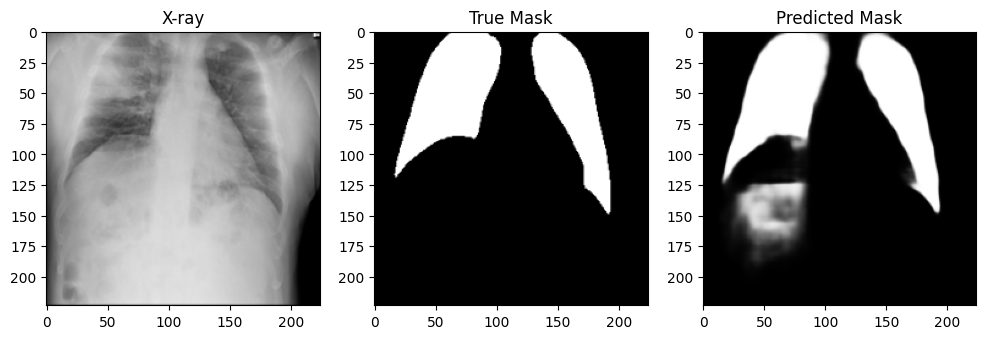

In [8]:
sample_imgs, sample_masks = val_gen[0]
pred_masks = model.predict(sample_imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("X-ray")
    plt.imshow(sample_imgs[i])
    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(sample_masks[i].squeeze(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.show()
